In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [25]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [26]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'./datasets/hospital_augment_train3.csv')

In [27]:
hospital_gen_train = list(df['gen_data'].iloc[:3000])
hospital_true_train = list(df['true_data'].iloc[:3000])

In [28]:
df_val = pd.read_csv(r'./datasets/hospital_augment_val3.csv')
df_test = pd.read_csv(r'./datasets/hospital_augment_test3.csv')

In [29]:
hospital_gen_val = list(df_val['gen_data'])
hospital_true_val = list(df_val['true_data'])
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [30]:
len(hospital_gen_train)

3000

In [31]:
# Preprocessing
import re
def process(sent):
    sent=sent.lower()
    sent=re.sub(r'[^0-9a-zA-Z ]','',sent)
    sent=sent.replace('\n','')
    return sent 

In [32]:
from pythainlp import thai_letters

In [33]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [34]:
char_set = label_map_0+label_map_1

In [35]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [36]:
count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [37]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [38]:
input_texts = []
target_texts = []

In [39]:
hospital_true_train[0]

'คลินิกกรุงเทพระยองสาขาบ่อวิน'

In [40]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i])
    target_texts.append(output_text)
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 3000


In [41]:
input_texts[0],target_texts[0]

('คลินิกกรุงเทพระยองาขาบ่อวิน', '\tคลินิกกรุงเทพระยองสาขาบ่อวิน\n')

In [42]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 72
Max Dec Len: 75


In [43]:
num_samples = len(input_texts)
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [44]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((3000, 72, 93), (3000, 75, 93), (3000, 75, 93))

In [45]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [46]:
len(input_texts),len(target_texts)

(3000, 3000)

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate,Embedding
import tensorflow as tf

In [82]:
batch_size = 128
epochs = 100
latent_dim = 128

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_input = Input(shape=(None,num_enc_tokens))
#encoder_emb = Embedding(num_enc_tokens, 64, input_length=num_enc_tokens,mask_zero=True)
encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True)) # Bidirectional(
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_input))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])

ValueError: Input 0 of layer bidirectional_6 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, None, 93, 64]

In [79]:
# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_emb = Embedding(input_dim=num_dec_tokens, output_dim=64)
decoder_lstm = LSTM(units=latent_dim*2, return_sequences=True, return_state=True) # units=units*2
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)

In [74]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [75]:
from tensorflow.keras.layers import Activation, dot, concatenate,Attention

attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(encoder_out, decoder_lstm_out)
decoder_combined_context = Concatenate(axis=-1, name='concat_layer')([decoder_lstm_out, attention_result])

In [76]:
decoder_dense = Dense(latent_dim, activation="tanh")(decoder_combined_context)
decoder_outputs = Dense(num_dec_tokens, activation="softmax")(decoder_dense)

In [80]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(None, None, 93), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [28]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [29]:
val_x = []
val_y = []
for i,line in enumerate(hospital_true_val):
    output_text = '\t' + line + '\n'
    val_x.append(hospital_gen_val[i])
    val_y.append(output_text)
print("LEN OF SAMPLES:",len(val_x))

LEN OF SAMPLES: 3353


In [30]:
max_enc_len_val = max([len(x)+x.count(' ') for x in val_x])
max_dec_len_val = max([len(x)+x.count(' ') for x in val_y])
print("Max Enc Len:",max_enc_len_val)
print("Max Dec Len:",max_dec_len_val)

Max Enc Len: 73
Max Dec Len: 75


In [31]:
##### Validation Set #####
num_samples_val = len(val_x)
encoder_input_data_val = np.zeros( (num_samples_val , max_enc_len_val , len(char_set)+3),dtype='float32' )
decoder_input_data_val = np.zeros( (num_samples_val , max_dec_len_val , len(char_set)+3),dtype='float32' )
decoder_target_data_val = np.zeros( (num_samples_val , max_dec_len_val , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [32]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(val_x,val_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_val[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_val[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_val[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")     

COMPLETED...


In [33]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 227328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [34]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=50)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_gendata_v1",
            save_best_only=True,
            monitor='accuracy',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [35]:
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 200,
          batch_size = batch_size)

==============================] - 1s 353us/sample - loss: 0.0288 - accuracy: 0.2734
Epoch 19/200
3000/3000 [==============================] - 1s 363us/sample - loss: 0.0298 - accuracy: 0.2730
Epoch 20/200
3000/3000 [==============================] - 1s 375us/sample - loss: 0.0307 - accuracy: 0.2727
Epoch 21/200
3000/3000 [==============================] - 1s 371us/sample - loss: 0.0296 - accuracy: 0.2730
Epoch 22/200
3000/3000 [==============================] - 1s 356us/sample - loss: 0.0268 - accuracy: 0.2739
Epoch 23/200
3000/3000 [==============================] - 1s 355us/sample - loss: 0.0248 - accuracy: 0.2744
Epoch 24/200
3000/3000 [==============================] - 1s 366us/sample - loss: 0.0238 - accuracy: 0.2748
Epoch 25/200
3000/3000 [==============================] - 1s 382us/sample - loss: 0.0232 - accuracy: 0.2748
Epoch 26/200
3000/3000 [==============================] - 1s 370us/sample - loss: 0.0230 - accuracy: 0.2749
Epoch 27/200
3000/3000 [============================

In [36]:
import matplotlib.pyplot as plt

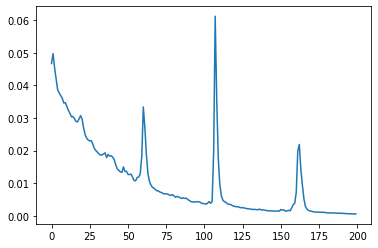

In [37]:
plt.plot(hist.history['loss'])

In [40]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v1.h5')
decoder_model.save('decoder_v1.h5')

In [34]:
from tensorflow.keras.models import load_model

In [39]:
encoder_model = load_model('encoder_v1.h5',compile=False)

In [40]:
decoder_model = load_model('decoder_v1.h5',compile=False)

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [42]:
pred_sent = []
for seq_index in range(num_samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

พยาบาลศรีสงคาม
Corrected sentence: โรงพยาบาลศรีสงคราม

Ground Truth: 	โรงพยาบาลศรีสงคราม

-
Wrong sentence: โรงพยาบาลศรีสมด็จ
Corrected sentence: โรงพยาบาลศรีสมเด็จ

Ground Truth: 	โรงพยาบาลศรีสมเด็จ

-
Wrong sentence: โรงพยาบาลศรีสวรร์
Corrected sentence: โรงพยาบาลศรีสวรรค์

Ground Truth: 	โรงพยาบาลศรีสวรรค์

-
Wrong sentence: โรงพยาบาศรีสะเกษ
Corrected sentence: โรงพยาบาลศรีสะเกษ

Ground Truth: 	โรงพยาบาลศรีสะเกษ

-
Wrong sentence: โรงพยาบาลศีสังวรสุโขทัย
Corrected sentence: โรงพยาบาลศรีสังวรสุโขทัย

Ground Truth: 	โรงพยาบาลศรีสังวรสุโขทัย

-
Wrong sentence: โรงพยาบาลศรีสชนาลัย
Corrected sentence: โรงพยาบาลศรีสัชนาลัย

Ground Truth: 	โรงพยาบาลศรีสัชนาลัย

-
Wrong sentence: โรงพยาาลศาลายา
Corrected sentence: โรงพยาบาลศาลายา

Ground Truth: 	โรงพยาบาลศาลายา

-
Wrong sentence: โรงพยาบาลศิครินทร
Corrected sentence: โรงพยาบาลศิครินทร์

Ground Truth: 	โรงพยาบาลศิครินทร์

-
Wrong sentence: โรงพยาบาลศิริราชปยมหาราชการุณย์
Corrected sentence: โรงพยาบาลศิริราชปิยมหาราชการุณย์

Ground Truth: 	โร

In [51]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test[:200]):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i])
    test_y.append(output_text)
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 200


In [52]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 52
Max Dec Len: 55


In [53]:
##### Validation Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [54]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [55]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

200/200 [==============================] - 5s 26ms/sample - loss: 1.7176 - accuracy: 0.0036


[1.7176105976104736, 0.0036363637]

In [56]:
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

คลินิกเวชกรรมสาขาเซนตหลุยส์
Corrected sentence: โรงพยาบาลไทย์คินทร์

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาเซนต์หลุยส์

-
Wrong sentence: เซ็นทรัลเมดิคลินิกเวชกรรมสาขาดินแดง
Corrected sentence: โรงพยาบาลธัญญารักษ์อุดร

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาดินแดง

-
Wrong sentence: เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาากเกร็ด
Corrected sentence: โรงพยาบาลนิคคำ ระ

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาปากเกร็ด

-
Wrong sentence: เซ็นทรัลเมดิกคลนิกเวชกรรมสาขาพระโขนง
Corrected sentence: โรงพยาบาลนาคูล

Ground Truth: 	เซ็นทรัลเมดิกคลินิกเวชกรรมสาขาพระโขนง

-
Wrong sentence: เเลแคร์คลินิกเจริญกรุง
Corrected sentence: โรงพยาบาลสาประหาทไวชป่ม

Ground Truth: 	เทเลแคร์คลินิกเจริญกรุง

-
Wrong sentence: เทเลแคร์คลินิกสหคลินิกสาาวัชรพล
Corrected sentence: โรงพยาบาลนาด้ำปาล

Ground Truth: 	เทเลแคร์คลินิกสหคลินิกสาขาวัชรพล

-
Wrong sentence: ธรรมุนทรคลินิกเวชกรรม
Corrected sentence: โรงพยาบาลนาดิน

Ground Truth: 	ธรรมสุนทรคลินิกเวชกรรม

-
Wrong sentence: ธรมสุนทรคลินิกเวชกรรมสาขาคลอง

In [68]:
enc_res = encoder_model.predict(encoder_input_data[0:1])
enc_res

[array([[-9.95659649e-01,  8.93459618e-01,  9.87632990e-01,
         -9.68996823e-01, -9.95487273e-01, -9.95516360e-01,
          9.93881941e-01, -6.29626811e-02, -2.53891218e-02,
          9.99175370e-01, -1.57290399e-01,  9.92826700e-01,
          9.75783646e-01, -9.40367639e-01,  9.97618854e-01,
          1.45655056e-03,  3.69537920e-02, -9.87444878e-01,
          9.87114072e-01,  8.14405978e-01, -1.02444544e-01,
          9.96736467e-01,  9.81696904e-01, -9.97525036e-01,
          6.43827841e-02,  9.91641283e-01,  9.96926129e-01,
          9.96977687e-01, -8.95909250e-01,  9.66639400e-01,
         -9.94550049e-01, -5.14646590e-01, -9.94808257e-01,
          9.95368719e-01, -9.92156029e-01, -8.20659220e-01,
          9.45004642e-01, -1.07101044e-02, -1.39255747e-01,
          9.91862774e-01, -9.04800594e-01,  9.78571773e-01,
          3.69586819e-03,  8.42870176e-01, -1.57688395e-03,
         -9.95695472e-01,  9.92269516e-01,  9.96642947e-01,
         -2.15249304e-02,  4.73221717e-0